# Interactive visualization of Gabor scattering

The interactive visualization grid shows the OutputA, OutputB and OutputC of Gabor scattering representation. With this visualization it is possible to see the changes in the outputs as frequency of frequency modulation and frequency of amplitude modulation changes. It is also possible to interact with the plot by changing parameters of Gabor scattering.

All the data for the plot are computed in advance and stored as a numpy array on a disk so the computation does not have to be done real time as the user interacts with the plot. Adjust the parameters to your liking, generate the array and use hypergrid() to start the interaction. But be careful - the bigger the parameter space, the bigger the numpy array and computation time.

In [1]:
# Making the synthetic/src visible in order to import the sound_gen
import sys
sys.path.append('../synthetic/src/')

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sound_gen import get_paramslist, harmonizer
from gabor_scattering import gs
import time

In [3]:
# Define the space of parameters that will be used in the visualization
# lx_over must be of the same len as lx_nfft, each element corresponding to a value in lx_nfft
# If you choose wrond combination of sr, l1_nfft and l2_nfft, problems with nperseg can arise
# f_fm and f_am should contain 5 elements in order for the plot to be readable
# Do not set too much parameters, the numpy array generated can be large (multiple GB)

space = {
    
    'out':  ['A', 'B', 'C'], # Labels for sliders
    'f_fm': [0,5,10,15,20], # Labels for axes
    'f_am': [20,15,10,5,0], # Labels for axes
    'l1_nfft': [250, 500], # Hypercube param and labels for axes
    'l1_over': [125, 250], # Map of the same len as l1_g
    'l2_nfft': [25, 50], # Hypercube param and labels for axes
    'l2_over': [20, 40], # Map of the same len as l2_g
    'sr':   [16000, 24000, 48000], # Hypercube param and labels for axes
    'nhar': [1,5], # Hypercube param and labels for axes
}

samleparams = {
    'sr': None,
    'dur': 1.0
}

baseparams = {
            'a': 1,
            'f': 1600,
            'p': 0,
            'a_fm': 1,
            'f_fm': None,
            'p_fm': 0,
            'a_am': 1,
            'f_am': None,
            'p_am': 0,
            }


gaborparams = {
        'l1_params' : {'nfft': None, 'nperseg': None, 'noverlap': None},
        'l2_params' : {'nfft': None, 'nperseg': None, 'noverlap': None},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (120, 120), 'outB': (120, 120), 'outC': (120, 120)},
        'return_outA': True,
        'return_outB': True, 
        'return_outC': True,
    }

In [4]:
def generate_hypercube(space, sampleparams, baseparams):

    hypercube = np.zeros((len(space['l1_nfft']),
                          len(space['l2_nfft']),
                          len(space['sr']),
                          len(space['nhar']),
                          len(space['f_am']),
                          len(space['f_fm']),
                          3, 120, 120))
    
    st = time.time()
    counter = 0
    for i, l1_nfft in enumerate(space['l1_nfft']):
        for j, l2_nfft in enumerate(space['l2_nfft']):
            for k, sr in enumerate(space['sr']):
                for l, nhar in enumerate(space['nhar']):
                    for m, f_am in enumerate(space['f_am']):
                        for n, f_fm in enumerate(space['f_fm']):
                            baseparams.update({'f_fm': f_fm, 'f_am': f_am})
                            paramslist = get_paramslist(baseparams, nharmonics=nhar)
                            gaborparams['l1_params'] = {'nfft': l1_nfft, 
                                                        'nperseg': l1_nfft, 
                                                        'noverlap': space['l1_over'][i]}
                            gaborparams['l2_params'] = {'nfft': l2_nfft, 
                                                        'nperseg': l2_nfft, 
                                                        'noverlap': space['l2_over'][j]}


                            wave = harmonizer(samleparams['dur'], sr, paramslist)

                            # Sanity check
                            if np.mean(wave) == 0: 
                                raise ValueError('Empty wave with params: \n {}'.format(paramslist))

                            try:
                                gabor = gs(wave, 
                                           l1_params=gaborparams['l1_params'], 
                                           l2_params=gaborparams['l2_params'],
                                           mel_params=None, 
                                           o2_params=gaborparams['o2_params'], 
                                           shapes=gaborparams['shapes'],
                                           return_outA=gaborparams['return_outA'],
                                           return_outB=gaborparams['return_outB'], 
                                           return_outC=gaborparams['return_outC'])
                            except Exception as e:
                                print(e)
                                print('Error occured using: ')
                                print(sr, nhar, gaborparams)
                                raise EnvironmentError

                            hypercube[i, j, k, l, m, n] = np.array([gabor['outA'], 
                                                                   gabor['outB'], 
                                                                   gabor['outC']])

                            counter += 1
                            if counter % 250 == 0:
                                print('Generated {} samples.'.format(counter))
                                print('Time so far {:.2f} s.'.format(time.time() - st))
    
    # Get the output type axis at the beginning
    hypercube = np.transpose(hypercube, (6, 0, 1, 2, 3, 4, 5, 7, 8))
    
    # Merge f_am and f_fm axes (m, n)
    hypercube = hypercube.reshape((*hypercube.shape[:5], 
                                   hypercube.shape[5] * hypercube.shape[6], 
                                   *hypercube.shape[7:]))
    
    return hypercube

In [5]:
hypercube = generate_hypercube(space, samleparams, baseparams)
np.save('data/hypercube.npy', hypercube)

Generated 250 samples.
Time so far 6.55 s.
Generated 500 samples.
Time so far 13.50 s.


In [6]:
def hypergrid(data, space):
    # https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html
    # https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html
    
    plt.rcParams['image.cmap']='magma_r'

    # Prepare the subplots with axes and desired layout
    fig, axes = plt.subplots(len(space['f_am']), len(space['f_fm']), sharex=True, sharey=True, 
                             figsize=(9.5, 9.5), num='Gabor Scattering')
    fig.subplots_adjust(left=0.03, bottom=0.03, right=1.0, top=0.98, wspace=0.05, hspace=0.05)
    axes = axes.ravel()

    # Set the initial view
    axims = []
    for x, ax in enumerate(axes):
        axims.append(ax.imshow(data[0,0,0,0,0,x][::-1], aspect='auto'))
        ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                       labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        ax.set(xlabel='f_fm = {} Hz'.format(space['f_fm'][int(x%len(space['f_fm']))]), 
               ylabel='f_am = {} Hz'.format(space['f_am'][int(np.floor(x/len(space['f_am'])))]))
        ax.label_outer()

    @interact(
        i = widgets.ToggleButtons(options=space['out'], description='Out'),
        j = widgets.SelectionSlider(options=space['l1_nfft'], value=space['l1_nfft'][0], description='L1 nfft', continuous_update=False),
        k = widgets.SelectionSlider(options=space['l2_nfft'], value=space['l2_nfft'][0], description='L2 nfft', continuous_update=False),
        l = widgets.SelectionSlider(options=space['sr'], value=space['sr'][0], description='sr', continuous_update=False),
        m = widgets.SelectionSlider(options=space['nhar'], value=space['nhar'][0], description='nhar', continuous_update=False))
   
    def hypg(i, j, k, l, m):

        # Map values
        a = space['out'].index(i)
        b = space['l1_nfft'].index(j)
        c = space['l2_nfft'].index(k)
        d = space['sr'].index(l)
        e = space['nhar'].index(m)

        for x, axim in enumerate(axims):
            axim.set_data(data[a, b, c, d, e, x][::-1])
            axim.autoscale()

<IPython.core.display.Javascript object>


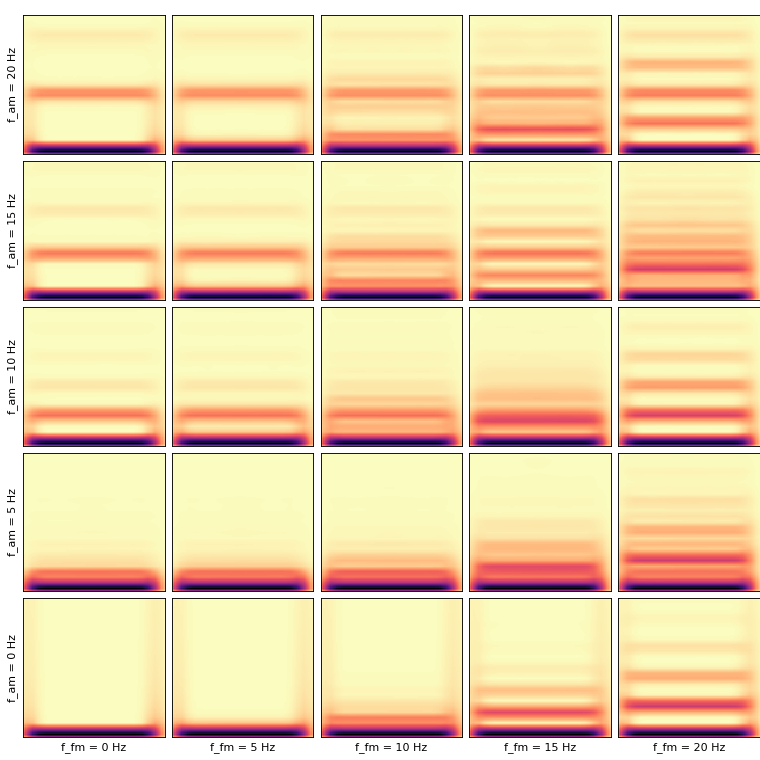

interactive(children=(ToggleButtons(description='Out', options=('A', 'B', 'C'), value='A'), SelectionSlider(co…

In [12]:
hypercube = np.load('data/hypercube.npy')
hypergrid(hypercube, space)